In [1]:
import tensorflow as tf
import boto3
import pandas as pd
from sagemaker import get_execution_role

import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 

import numpy as np
role = get_execution_role()

In [200]:
# read data from bucket
bucket_name='ee542temperatureflowdata'

features_fire, features_nonfire =[], []

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

for obj in bucket.objects.all():
    if '.txt' in obj.key:
        data_key = obj.key
        data_location = 's3://{}/{}'.format(bucket_name, data_key)
        
        if'none' in obj.key:
#             print("Nonfire: ", obj.key)
            
            df_nonfire = pd.read_csv(data_location,header=None,sep=" ")
#             print(df_nonfire.values[0].tolist())
            
            if not isinstance(df_nonfire.values[0][0],str):
                feature = np.reshape(df_nonfire.values[0].tolist(),(1,2))
                if features_nonfire == []:
                    features_nonfire = feature
                else:
                    features_nonfire = np.append(features_nonfire,feature, axis = 0)
            
        else:
            df_fire = pd.read_csv(data_location,header=None,sep=" ")
            
            if not isinstance(df_fire.values[0][0],str):
                feature = np.reshape(df_fire.values[0].tolist(),(1,2))
                if features_fire == []:
                    features_fire = feature
                else:
                    features_fire = np.append(features_fire,feature, axis = 0)
        if'boilingwater' in obj.key:
#             print("Nonfire: ", obj.key)
            
            df_nonfire = pd.read_csv(data_location,header=None,sep=" ")
#             print(df_nonfire.values[0].tolist())
            
            if not isinstance(df_nonfire.values[0][0],str):
                feature = np.reshape(df_nonfire.values[0].tolist(),(1,2))
                if features_nonfire == []:
                    features_nonfire = feature
                else:
                    features_nonfire = np.append(features_nonfire,feature, axis = 0)
            
            
# print(features_fire.shape)
print(features_nonfire.shape)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:44: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


(211, 2)


In [12]:
np.save("MQ_TEMP_fire", features_fire)
np.save("MQ_TEMP_nonfire", features_nonfire)
np.save("MQ_TEMP_boilingwater", features_nonfire)
features_load = np.load("MQ_TEMP_boilingwater.npy")
print(features_load.shape)

(211, 2)


In [2]:
import numpy as np
## load processed data directly
features_nonfire = np.load("MQ_TEMP_nonfire.npy")
features_fire = np.load("MQ_TEMP_fire.npy")
features_boilingwater = np.load("MQ_TEMP_boilingwater.npy")
features = np.zeros((600,2))
features[0:200,:] = features_fire[0:200]
features[200:400,:] = features_nonfire[0:200]
features[400:600,:] = features_boilingwater[0:200]
labels = np.zeros((600,1))
labels[0:200,:] = np.ones((200,1))
print(features.shape)
print(labels.shape)


# from sklearn.preprocessing import MinMaxScaler
# min_max_scaler = MinMaxScaler()
# features = min_max_scaler.fit_transform(features)

# print(features)
# print(labels)

(600, 2)
(600, 1)


In [3]:
!pip install imblearn ##install package 

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

train, test, labels_train, labels_test = train_test_split(features, labels, test_size=0.1) ##use 10% data for validation
print(test.shape)
print(labels_test.shape)

smote = SMOTE()
train, labels_train = smote.fit_sample(train, labels_train)
print(train.shape)

test, labels_test = smote.fit_sample(test, labels_test)
print(test.shape)

train = np.reshape(train,(train.shape[0],2,1))
test = np.reshape(test,(test.shape[0],2,1))
print(train.shape)

    100% |████████████████████████████████| 163kB 7.8MB/s ta 0:00:01
    100% |████████████████████████████████| 7.0MB 4.1MB/s ta 0:00:011    63% |████████████████████▍           | 4.5MB 39.1MB/s eta 0:00:01
  Found existing installation: scikit-learn 0.21.3
    Uninstalling scikit-learn-0.21.3:
      Successfully uninstalled scikit-learn-0.21.3
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
(60, 2)
(60, 1)
(716, 2)
(84, 2)
(716, 2, 1)


Using TensorFlow backend.
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [4]:
from tensorflow.keras import layers
batch = 1

In [5]:
def make_model():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(2,1),batch_size = batch),
        tf.keras.layers.LSTM(16,
                            return_sequences=True,
                            stateful=True,
                            recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(8,activation=tf.nn.relu),
        tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)
      ]
    )

    return model

In [6]:
model = make_model()
model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (1, 2, 16)                1152      
_________________________________________________________________
flatten (Flatten)            (1, 32)                   0         
_________________________________________________________________
dense (Dense)                (1, 8)                    264       
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    9         
Total params: 1,425
Trainable params: 1,425
Non-trainable params: 0
_________________________________________________________________


In [7]:
model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [9]:
model.fit(train, labels_train,
          validation_data=(test, labels_test),
          batch_size=batch,
          epochs=10)

Train on 716 samples, validate on 84 samples
Epoch 1/10
716/716 [==============================] - 3s 5ms/sample - loss: 0.2676 - acc: 0.8589 - val_loss: 0.3200 - val_acc: 0.8095
Epoch 2/10
716/716 [==============================] - 3s 5ms/sample - loss: 0.2592 - acc: 0.8757 - val_loss: 0.2548 - val_acc: 0.9048
Epoch 3/10
716/716 [==============================] - 3s 5ms/sample - loss: 0.2672 - acc: 0.8715 - val_loss: 0.2772 - val_acc: 0.9048
Epoch 4/10
716/716 [==============================] - 3s 5ms/sample - loss: 0.2573 - acc: 0.8729 - val_loss: 0.2584 - val_acc: 0.8929
Epoch 5/10
716/716 [==============================] - 3s 5ms/sample - loss: 0.2627 - acc: 0.8785 - val_loss: 0.2572 - val_acc: 0.9167
Epoch 6/10
716/716 [==============================] - 3s 4ms/sample - loss: 0.2591 - acc: 0.8701 - val_loss: 0.2737 - val_acc: 0.9048
Epoch 7/10
716/716 [==============================] - 3s 5ms/sample - loss: 0.2541 - acc: 0.8715 - val_loss: 0.2792 - val_acc: 0.8929
Epoch 8/10
716/71

In [11]:
## load test data from bucket and test in real time
## Santiago, you can use model.predict(test_feature) as the value in your while loop
import time

bucket_name='ee542temperatureflowdata'

features_fire, features_nonfire =[], []

s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_name)

for i in range(100):
# while model.predict(test_feature) < 0.5:
    for obj in bucket.objects.all():
        if 'testdata.txt' in obj.key:
            data_key = obj.key
            data_location = 's3://{}/{}'.format(bucket_name, data_key)    
            df = pd.read_csv(data_location,header=None,sep=" ") 
            if not isinstance(df.values[0][0],str):
                feature = np.reshape(df.values[0].tolist(),(1,2))
#     print(feature)
    test_feature = np.reshape(feature,(1,2,1))
    print(model.predict(test_feature)) ##this predict funtion provides the value ranges in [0,1], 0 is nonfire, 1 is fire
    time.sleep(3)
    if model.predict(test_feature) > 0.5:
        print("fire")

[[0.00917454]]
[[0.00840384]]
[[0.00829159]]
[[0.00728238]]
[[0.00723005]]
[[0.00721157]]
[[0.00720348]]
[[0.00828564]]
[[0.0084251]]
[[0.00843581]]
[[0.00844093]]
[[0.00844295]]
[[0.00844373]]
[[0.00844403]]
[[0.999124]]
fire
[[0.9990977]]
fire
[[0.9990963]]
fire
[[0.9990958]]
fire
[[0.8758796]]
fire
[[0.7936827]]
fire
[[0.7883296]]
fire
[[0.00991586]]
[[0.00938181]]
[[0.00930042]]
[[0.00928879]]
[[0.00779406]]
[[0.00784934]]
[[0.00781975]]
[[0.00295134]]
[[0.00276849]]
[[0.00275891]]
[[0.00275499]]
[[0.01085025]]
[[0.01090875]]
[[0.01098061]]
[[0.99989295]]
fire
[[0.9999261]]
fire
[[0.9999268]]
fire
[[0.9999269]]
fire
[[0.9995047]]
fire
[[0.99963236]]
fire
[[0.9996264]]
fire
[[0.00378258]]
[[0.00303736]]
[[0.00287978]]
[[0.00280789]]


KeyboardInterrupt: 

In [211]:
# test_features = np.reshape(features_load[200:,],(11,2,1))
# print(test_features.shape)
# print(model.predict(test_features))

(4160, 3120, 3)


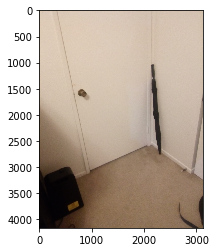

In [82]:
# img = mpimg.imread('sample.jpg') 
# print(img.shape)
# plt.imshow(img) 

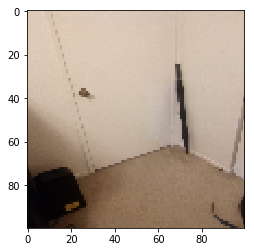

In [115]:
from PIL import Image  
img = Image.open('sample.jpg')
newsize = (100, 100) 
img = img.resize(newsize)  
plt.imshow(img) 

In [79]:
# print(np.asarray(img))

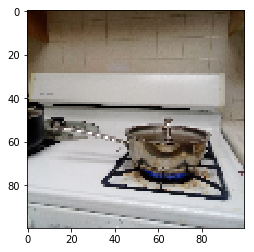

In [257]:
img_fire1 = Image.open('fire1.jpg')
img_fire1 = img_fire1.resize(newsize)  
plt.imshow(img_fire1) 
img_fire2 = Image.open('fire2.jpg')
img_fire2 = img_fire2.resize(newsize)  
plt.imshow(img_fire2) 
img_fire3 = Image.open('fire3.JPG')
img_fire3 = img_fire3.resize(newsize)  
plt.imshow(img_fire3) 
img_fire4 = Image.open('fire4.jpg')
img_fire4 = img_fire4.resize(newsize)  
plt.imshow(img_fire4) 
img_fire5 = Image.open('fire5.jpg')
img_fire5 = img_fire5.resize(newsize)  
plt.imshow(img_fire5) 


img_nofire1 = Image.open('nofire1.jpg')
img_nofire1 = img_nofire1.resize(newsize)  
plt.imshow(img_nofire1) 
img_nofire2 = Image.open('nofire2.jpg')
img_nofire2 = img_nofire2.resize(newsize)  
plt.imshow(img_nofire2) 
img_nofire3 = Image.open('sample.jpg')
img_nofire3 = img_nofire3.resize(newsize)  
plt.imshow(img_nofire3) 

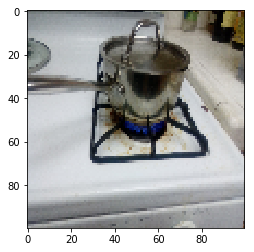

In [231]:
img_boiling1 = Image.open('boiling1.jpg')
img_boiling1 = img_boiling1.resize(newsize)  
plt.imshow(img_boiling1) 

# img_boiling2 = Image.open('boiling2.jpg')
# img_boiling2 = img_boiling2.resize(newsize)  
# plt.imshow(img_boiling2) 

In [265]:
labels = np.zeros((10,1))
labels[5:10] = np.ones((5,1))
print(labels)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [262]:
features = np.zeros((10,100,100,3))

features[0,] = img_nofire1
features[1,] = img_nofire2
features[2,] = img_nofire3
features[3,] = img_boiling1
features[4,] = img_boiling2
features[5,] = img_fire1
features[6,] = img_fire2
features[7,] = img_fire3
features[8,] = img_fire4
features[9,] = img_fire5
# print(features[0])

In [263]:
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
def make_model_img():
    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(100, 100, 3),batch_size=1),
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(100, 100,3)),
        MaxPooling2D(),
#         Conv2D(32, 3, padding='same', activation='relu'),
#         MaxPooling2D(),
#         Conv2D(64, 3, padding='same', activation='relu'),
#         MaxPooling2D(),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
      ]
    )

    return model

In [264]:
model_img = make_model_img()
model_img.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (1, 100, 100, 16)         448       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (1, 50, 50, 16)           0         
_________________________________________________________________
flatten_17 (Flatten)         (1, 40000)                0         
_________________________________________________________________
dense_34 (Dense)             (1, 64)                   2560064   
_________________________________________________________________
dense_35 (Dense)             (1, 1)                    65        
Total params: 2,560,577
Trainable params: 2,560,577
Non-trainable params: 0
_________________________________________________________________


In [266]:
model_img.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [267]:
model_img.fit(features, labels,
          validation_data=(features, labels),
          batch_size=1,
          epochs=15)

Train on 10 samples, validate on 10 samples
Epoch 1/15
10/10 [==============================] - 1s 88ms/sample - loss: 874.6669 - acc: 0.4000 - val_loss: 96.1580 - val_acc: 0.5000
Epoch 2/15
10/10 [==============================] - 0s 17ms/sample - loss: 68.1521 - acc: 0.5000 - val_loss: 3.6680 - val_acc: 0.5000
Epoch 3/15
10/10 [==============================] - 0s 17ms/sample - loss: 25.8633 - acc: 0.2000 - val_loss: 0.3032 - val_acc: 0.9000
Epoch 4/15
10/10 [==============================] - 0s 18ms/sample - loss: 2.7312 - acc: 0.7000 - val_loss: 2.2951 - val_acc: 0.7000
Epoch 5/15
10/10 [==============================] - 0s 17ms/sample - loss: 1.1169 - acc: 0.9000 - val_loss: 0.2432 - val_acc: 0.9000
Epoch 6/15
10/10 [==============================] - 0s 18ms/sample - loss: 0.5556 - acc: 0.8000 - val_loss: 0.0722 - val_acc: 1.0000
Epoch 7/15
10/10 [==============================] - 0s 17ms/sample - loss: 0.0323 - acc: 1.0000 - val_loss: 2.0612e-06 - val_acc: 1.0000
Epoch 8/15
10/10

array([[2.0214984e-06]], dtype=float32)

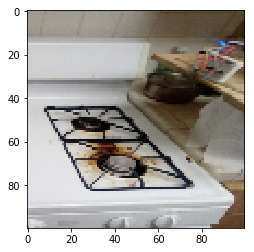

In [268]:
img_nofire4 = Image.open('nofire4.jpg')
img_nofire4 = img_nofire4.resize(newsize)  
plt.imshow(img_nofire4) 

img_nofire4 = np.reshape(np.asarray(img_nofire4),(1,100,100,3))
model_img.predict(img_nofire4)

array([[0.00033866]], dtype=float32)

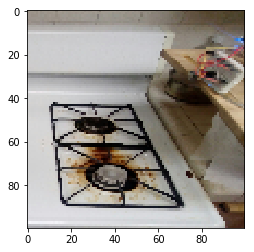

In [269]:
img_nofire5 = Image.open('nofire5.jpg')
img_nofire5 = img_nofire5.resize(newsize)  
plt.imshow(img_nofire5) 

img_nofire5 = np.reshape(np.asarray(img_nofire5),(1,100,100,3))
model_img.predict(img_nofire5)

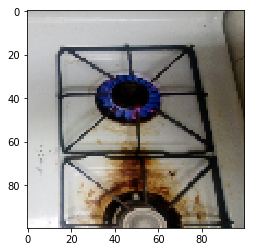

In [270]:
img_fire1 = Image.open('fire1.jpg')
img_fire1 = img_fire1.resize(newsize)  
plt.imshow(img_fire1) 

In [293]:
%%bash
sudo chmod 400 542Final.pem

In [294]:
%%bash
ssh -i 542Final.pem ec2-user@ec2-3-17-69-74.us-east-2.compute.amazonaws.com "bash imgcap2.sh; exit"

upload: ../../pics/testpic2.jpg to s3://ee542temperatureflowdata/testpic2.jpg


In [309]:
%%bash
aws s3 cp s3://ee542temperatureflowdata/testpic2.jpg ./sample.jpg

download: s3://ee542temperatureflowdata/testpic2.jpg to ./sample.jpg


AxesImage(54,36;334.8x217.44)


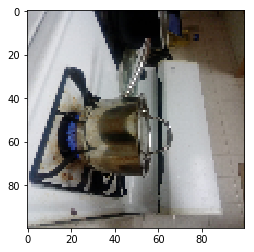

In [310]:
img_test = Image.open('sample.jpg')
img_test = img_test.resize(newsize)  
print(plt.imshow(img_test) )

In [311]:
img_test = np.reshape(np.asarray(img_test),(1,100,100,3))

print(model_img.predict(img_test)) ##this predict funtion provides the value ranges in [0,1], 0 is nonfire, 1 is fire

[[0.00016727]]
